##  Trabajo práctico 2: Clasificación aplicada a la EPH
### Grupo 8: Banfi, Catalina; Lima, Matías; López, Santiago. 

In [1]:
import os  
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt  # Para matriz de correlaciones
import statsmodels.api as sm     

from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import plot_roc_curve
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from scipy.special import expit

Lo primero que hago se hace es crear un botón que permita esconder todas las celdas que sean código y mostrar todo lo demás si se lo desea. La solución no es original, sino que se obtuvo de una provista por el usuario de Stack Overflow Eric Shepherd en el siguiente link: https://stackoverflow.com/a/53136940

In [2]:
import ipywidgets as widgets
from IPython.display import display, HTML

javascript_functions = {False: "hide()", True: "show()"}
button_descriptions  = {False: "Show code", True: "Hide code"}


def toggle_code(state):

    """
    Toggles the JavaScript show()/hide() function on the div.input element.
    """

    output_string = "<script>$(\"div.input\").{}</script>"
    output_args   = (javascript_functions[state],)
    output        = output_string.format(*output_args)

    display(HTML(output))


def button_action(value):

    """
    Calls the toggle_code function and updates the button description.
    """

    state = value.new

    toggle_code(state)

    value.owner.description = button_descriptions[state]


state = False
toggle_code(state)

button = widgets.ToggleButton(state, description = button_descriptions[state])
button.observe(button_action, "value")

display(button)

ToggleButton(value=False, description='Show code')

También se suma el siguiente código para ocultar las warnings, entendiendo que las mismas son útiles pero molestas en el caso de una presentación cuando ya se entendió el motivo de las mismas. Por este motivo, también se deja comentada una línea que permite limitar la cantidad de advertencias por acción a 1. 

In [3]:
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')

## PARTE 1: ANALIZANDO LA BASE

In [5]:
#Importamos la EPH

base_indec = pd.read_excel("usu_individual_T122.xlsx")

#### a. Elimine todas las observaciones que no corresponden a los aglomerados de Ciudad Autónoma de Buenos Aires o Gran Buenos Aires

In [6]:
# Filtramos la base para que unicamente queden los aglomerados 32 (Provincia de Buenos Aires) y 33(Capital Federal)
base_indec_bs = base_indec[(base_indec['AGLOMERADO'] == 32) | (base_indec['AGLOMERADO'] == 33)]

#### b. Si hay observaciones con valores que no tienen sentido, descártelas (ingresos y edades negativos, por ejemplo)

In [7]:
# Purgamos la base de observaciones no validas
base_indec_bs = base_indec_bs[(base_indec_bs['ITF'] >= 0) | (base_indec_bs['T_VI'] >= 0)| (base_indec_bs['IPCF'] >= 0) | (base_indec_bs['P21'] >= 0)] # Borramos los ingresos negativos (tanto laborales como no laborales) 
base_indec_bs = base_indec_bs[(base_indec_bs['CH06'] >= 0)] #borramos las edades negativas

#### c. Una vez hecha esa limpieza, realice un gráfico de barras mostrando la composición por sexo.

In [8]:
# Calculamos el porcentaje de hombres y mujeres en la base
share_varones = (base_indec_bs['CH04']==1).sum()/(len(base_indec_bs)-1)*100
share_mujeres = (base_indec_bs['CH04']==2).sum()/(len(base_indec_bs)-1)*100

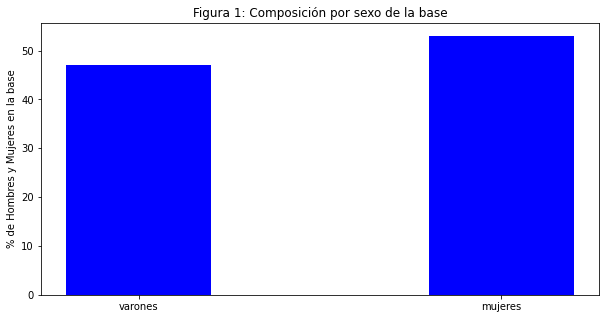

In [9]:
# Graficamos los shares de hombres y mujeres en la base
df = {'varones':share_varones, 'mujeres':share_mujeres}
Sexo = list(df.keys())
values = list(df.values())

fig = plt.figure(figsize = (10, 5))

plt.bar(Sexo, values, color = 'blue', width = 0.4)
plt.ylabel("% de Hombres y Mujeres en la base")
plt.title('Figura 1: Composición por sexo de la base')

fig.savefig('figura1.png')

#### d. Realice una matriz de correlación con las siguientes variables: CH04, CH07, CH08, NIVEL_ED, ESTADO, CAT_INAC, IPCF

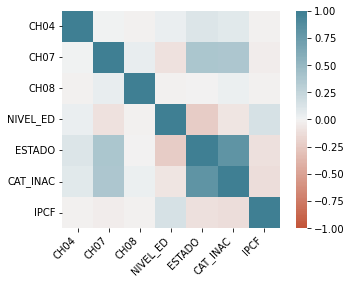

In [10]:
# Creamos una base auxiliar para calcular la correlacion entre las variables pedidas
base_corr = base_indec_bs[['CH04', 'CH07', 'CH08', 'NIVEL_ED', 'ESTADO', 'CAT_INAC', 'IPCF']]

import seaborn as sns
# Creamos un grafico de correlacion
corr = base_corr.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);


In [11]:
# Guardamos la figura
results_path = 'results.png'
plt.savefig(results_path)

<Figure size 432x288 with 0 Axes>

#### e. ¿Cuántos desocupados hay en la muestra? ¿Cuántos inactivos? ¿Cuál es la media de ingreso per cápita familiar (IPCF) según estado (ocupado, desocupado, inactivo)?

In [12]:
# Sabiendo que estado = 2: desocupado, = 3: inactivo
des = sum(1 for i in base_indec_bs['ESTADO'] if i == 2) #contamos la cantidad de desocupados
print("La cantidad de desocupados es", des)
inac = sum(1 for i in base_indec_bs['ESTADO'] if i == 3) #contamos la cantidad de inactivos
print("La cantidad de inactivos es", inac)

La cantidad de desocupados es 232
La cantidad de inactivos es 2695


In [13]:
# Filtramos las bases por ocupados, desocupados e inactivos
base_indec_bs_ocupados = base_indec_bs[(base_indec_bs['ESTADO'] == 1)]
base_indec_bs_desocupados = base_indec_bs[(base_indec_bs['ESTADO'] == 2)]
base_indec_bs_inactivos = base_indec_bs[(base_indec_bs['ESTADO'] == 3)]

# Imprimimos el promedio de ingreso segun la categoria
print("La media de ingreso per capita familiar por ocupados es ", round(base_indec_bs_ocupados['IPCF'].mean(),2))
print("La media de ingreso per capita familiar por desocupados es ", round(base_indec_bs_desocupados['IPCF'].mean(), 2))
print("La media de ingreso per capita familiar por inactivos es ", round(base_indec_bs_inactivos['IPCF'].mean(), 2))




La media de ingreso per capita familiar por ocupados es  31092.3
La media de ingreso per capita familiar por desocupados es  14757.69
La media de ingreso per capita familiar por inactivos es  22350.18


#### f. Utilizando el archivo tabla_adulto_equiv.xlsx, agregue una columna a su base de datos llamada adulto_equiv que contenga los valores de adulto equivalente de cada persona según su sexo y edad (por ejemplo, a un varón de 2 años le corresponde 0.46). Finalmente, con el comando groupby sume esta nueva columna para las personas que pertenecen a un mismo hogar y guarde ese dato en una columna llamada ad_equiv_hogar1.

In [16]:
# Importamos y limpiamos las filas vacias de la tabla de equivalencias
tabla_equivalencias = pd.read_excel("tabla_adulto_equiv.xlsx", skiprows=[0, 1, 2, 4, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39])

In [17]:
# Cambiamos una fila de la tabla de equivalencias para que sea igual a nuestros datos
tabla_equivalencias.at[1, 'Edad'] = '1 años'
tabla_equivalencias.head()


,Edad,Mujeres,Varones
0,Menor de 1 año,0.35,0.35
1,1 años,0.37,0.37
2,2 años,0.46,0.46
3,3 años,0.51,0.51
4,4 años,0.55,0.55


In [18]:
# Creamos una funcion lambda donde, segun el rango de edad, genera otra columna con el mismo formato que el de tabla de equivalencias 
base_indec_bs['Edad'] = base_indec_bs['CH06'].apply(lambda x: '61 a 75 años' if x >= 61 and x <= 75 else ('46 a 60 años' if x >= 46 and x <= 60 else 
                                                                                                          ('30 a 45 años' if x >= 30 and x <= 45 else 
                                                                                                           ('18 a 29 años' if x >= 18 and x <= 29 else
                                                                                                           ('más de 75 años' if x > 75 else ('Menor de 1 año' if x < 1 else
                                                                                                                                             str(x)+ ' años'))))))

# Hacemos el mismo proceso anterior pero ahora para una tabla de genero
base_indec_bs['Genero'] = base_indec_bs['CH04'].apply(lambda x: 'Varones' if x <= 1 else 'Mujeres') 

In [19]:
# Partimos la base en dos (mujeres y hombres) para agilizar el proximo loop
base_mujeres =  base_indec_bs[(base_indec_bs['CH04'] == 2)]
base_varones = base_indec_bs[(base_indec_bs['CH04'] == 1)]

In [20]:
# Para la base de mujeres, corremos un loop que busca por cada valor de la columna Edad, en la base del INDEC, y lo matchea con los valores de la columna Mujeres, de la tabla de equivalencias.

lista = []
for i in range(0, len(base_mujeres)):
    for x in range(0, len(tabla_equivalencias)):
        if base_mujeres.iloc[i]['Edad'] == tabla_equivalencias.iloc[x]['Edad']:
             lista.append(tabla_equivalencias.iloc[x]['Mujeres'])
base_mujeres['adulto_equiv'] = lista

In [21]:
# Repetimos el mismo proceso para la base de Hombres
lista_2 = []
for i in range(0, len(base_varones)):
    for x in range(0, len(tabla_equivalencias)):
        if base_varones.iloc[i]['Edad'] == tabla_equivalencias.iloc[x]['Edad']:
             lista_2.append(tabla_equivalencias.iloc[x]['Varones'])
base_varones['adulto_equiv'] = lista_2   
    

In [22]:
# Unimos ambas bases 

base_indec_bs = base_mujeres.append(base_varones)


In [23]:
#Finamente, creamos la columna de equivalencias nutricionales por hogar
data = base_indec_bs.groupby(['CODUSU']).sum()[['adulto_equiv']]
data = data.rename(columns={'adulto_equiv':'ad_equiv_hogar'})


#### 3. Uno de los grandes problemas de la EPH es la creciente cantidad de hogares que no reportan sus ingresos (ver por ejemplo el siguiente informe). ¿Cuántas personas no respondieron cuál es su ingreso total familiar (ITF)? Guarde como una base distinta las observaciones donde respondieron la pregunta sobre su ITF bajo el nombre respondieron. Las observaciones con ITF=0 guárdelas bajo el nombre norespondieron.

In [24]:
base_indec_bs = base_indec_bs.merge(data, left_on='CODUSU', right_on='CODUSU', how='outer')

In [25]:
# Calculamos las personas que no respondieron cual es su ingreso familiar
no_ITF = sum(1 for i in base_indec_bs['ITF'] if i == 0)
print(no_ITF, "personas no respondieron cuál es su ingreso total familiar")

2904 personas no respondieron cuál es su ingreso total familiar


In [26]:
# Creamos las bases pedidas en la consigna
respondieron =  base_indec_bs[(base_indec_bs['ITF'] > 0)]
norespondieron = base_indec_bs[(base_indec_bs['ITF'] == 0)]

#### 4. Sabiendo que la Canasta Básica Total para un adulto equivalente en el Gran Buenos Aires en el primer trimestre de 2022 es aproximadamente 27.197,64, agregue a la base respondieron una columna llamada ingreso_necesario que sea el producto de este valor por ad_equiv_hogar. Note que este es el valor mínimo que necesita ese hogar para no ser pobre

In [27]:
respondieron['ingreso_necesario'] = respondieron['ad_equiv_hogar'].apply(lambda x: x*27197.64)

In [28]:
def pobre(respondieron):
    '''
    esta función busca si los ingresos totales familiares son menores que los ingresos necesarios
    para que un hogar no sea pobre, así como lo contrario, y nos devuelve un 1 si se cumple que 
    los ingresos totales son menores que los necesarios, y un 0 si son mayores o iguales. 
    '''
    if respondieron['ITF'] < respondieron['ingreso_necesario']:
        return 1
    elif respondieron['ITF'] >= respondieron['ingreso_necesario']:
        return 0

#### 5. Por último, agregue a respondieron una columna llamada pobre que tome valor 1 si el ITF es menor al ingreso_necesario que necesita esa familia, y 0 en caso contrario. ¿Cuántos pobres identificó?

In [29]:
#ahora creamos una columna nueva que surge de aplicar la función que definimos a nuestra base de datos. 
respondieron['pobre'] = respondieron.apply(pobre, axis=1)

#ahora contamos la cantidad de veces que aparece un 1 en la columna pobre para saber la cantidad de pobres que hay en la 
#muestra
pobres = sum(1 for i in respondieron['pobre'] if i == 1)
print("Identificamos", pobres, "pobres en la base")

Identificamos 1190 pobres en la base


## PARTE 2: CLASIFICACION

#### 1. Elimine de ambas bases todas las variables relacionadas a ingresos (en el archivo codigos_eph.pdf ver las categorías: ingresos de la ocupación principal de los asalariados, ingresos de la ocupación principal, ingresos de otras ocupaciones, ingreso total individual, ingresos no laborales, ingreso total familiar, ingreso per cápita familiar). Elimine también las columnas adulto_equiv, ad_equiv_hogar e ingreso_necesario.

In [30]:
# Eliminamos las variables relacionadas a ingresos y las columnas de las bases respondieron/no respondieron
respondieron = respondieron.drop(['PP08D1', 'PP08D4', 'PP08F1', 'PP08F2', 'PP08J1', 'PP08J2', 'PP08J3'], axis=1) # ingresos de la ocupación principal de los asalariados
respondieron = respondieron.drop(['P21', 'DECOCUR', 'IDECOCUR', 'RDECOCUR', 'GDECOCUR', 'PDECOCUR', 'ADECOCUR', 'TOT_P12'], axis=1) # ingresos de la ocupación principal y de otras ocupaciones
respondieron = respondieron.drop(['P47T', 'DECINDR', 'IDECINDR', 'RDECINDR', 'GDECINDR', 'PDECINDR', 'ADECINDR'], axis=1) # ingresos total individual
respondieron = respondieron.drop(['V2_M', 'V3_M', 'V4_M', 'V5_M', 'V8_M', 'V9_M', 'V10_M', 'V11_M', 'V12_M', 'V18_M', 'V19_AM', 'V21_M', 'T_VI'], axis=1) # ingresos no laborales
respondieron = respondieron.drop(['ITF', 'DECIFR', 'IDECIFR', 'RDECIFR', 'GDECIFR', 'PDECIFR', 'ADECIFR'], axis=1) # ingreso total familiar
respondieron = respondieron.drop(['IPCF', 'DECCFR', 'IDECCFR', 'RDECCFR', 'GDECCFR', 'PDECCFR', 'ADECCFR'], axis=1) # ingreso per capita familiar
respondieron = respondieron.drop(['adulto_equiv', 'ad_equiv_hogar', 'ingreso_necesario'], axis=1) # columnas adulto_equiv, ad_equiv_hogar e ingreso_necesario

norespondieron = norespondieron.drop(['PP08D1', 'PP08D4', 'PP08F1', 'PP08F2', 'PP08J1', 'PP08J2', 'PP08J3'], axis=1) # ingresos de la ocupación principal de los asalariados
norespondieron = norespondieron.drop(['P21', 'DECOCUR', 'IDECOCUR', 'RDECOCUR', 'GDECOCUR', 'PDECOCUR', 'ADECOCUR', 'TOT_P12'], axis=1) # ingresos de la ocupación principal y de otras ocupaciones
norespondieron = norespondieron.drop(['P47T', 'DECINDR', 'IDECINDR', 'RDECINDR', 'GDECINDR', 'PDECINDR', 'ADECINDR'], axis=1) # ingresos total individual
norespondieron = norespondieron.drop(['V2_M', 'V3_M', 'V4_M', 'V5_M', 'V8_M', 'V9_M', 'V10_M', 'V11_M', 'V12_M', 'V18_M', 'V19_AM', 'V21_M', 'T_VI'], axis=1) # ingresos no laborales
norespondieron = norespondieron.drop(['ITF', 'DECIFR', 'IDECIFR', 'RDECIFR', 'GDECIFR', 'PDECIFR', 'ADECIFR'], axis=1) # ingreso total familiar
norespondieron = norespondieron.drop(['IPCF', 'DECCFR', 'IDECCFR', 'RDECCFR', 'GDECCFR', 'PDECCFR', 'ADECCFR'], axis=1) # ingreso per capita familiar
norespondieron = norespondieron.drop(['adulto_equiv', 'ad_equiv_hogar'], axis=1) # columnas adulto_equiv, ad_equiv_hogar e ingreso_necesario



#### 2. Parta la base respondieron en base de prueba (test) y base de entrenamiento (train) utilizando el comando train_test_split. La base de entrenamiento debe comprender el 70 % de los datos, y la semilla a utilizar (random state instance) debe ser 101. Establezca a pobre como su variable dependiente en la base de entrenamiento (vector y). El resto de las variables serán las variables independientes (matriz X). Recuerde agregar la columna de 1

In [31]:
y = respondieron['pobre']
# Nos quedamos con las variables de la base que nos sirven para hacer la regresion
x = respondieron[['CH06', 'CH04' , 'ESTADO', 'NIVEL_ED' , 'CH03' , 'CH07' , 'CH08',  'CH09' , 'CH10' , 'CH11', 'CH12' , 'CH13' , 'CH16' ,'PP02C1', 'PP02C2', 'PP02C3', 'PP02C4', 'PP02C6', 'PP02E','PP02H'
]]

x = sm.add_constant(x) # Agregamos la columna de unos.

x['ESTADO'] = pd.Categorical(x['ESTADO'])
x['CH03'] = pd.Categorical(x['CH03']) 
x['NIVEL_ED'] = pd.Categorical(x['NIVEL_ED'])
x['CH07'] = pd.Categorical(x['CH07'])
x['CH08'] = pd.Categorical(x['CH08'])
x['CH09'] = pd.Categorical(x['CH09'])
x['CH10'] = pd.Categorical(x['CH10'])
x['CH11'] = pd.Categorical(x['CH11'])
x['CH12'] = pd.Categorical(x['CH12'])
x['CH13'] = pd.Categorical(x['CH12'])
x['CH16'] = pd.Categorical(x['CH16'])
x['PP02C2'] = pd.Categorical(x['PP02C2'])
x['PP02C3'] = pd.Categorical(x['PP02C3'])
x['PP02C4'] = pd.Categorical(x['CH04'])
x['PP02C6'] = pd.Categorical(x['CH03'])
x['PP02E'] = pd.Categorical(x['PP02E'])
x['PP02H'] = pd.Categorical(x['PP02H'])

# Partimos la base en una de entrenamiento (70%) y otra de prueba (30%)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.30, random_state=101)                                   

#### 3. Implemente los siguientes métodos reportando luego la matriz de confusión, la curva ROC y los valores de AUC y de Accuracy de cada uno:

#### Logit

Matriz de confusión Logit:
[[690  72]
 [265  97]]
La precisión del modelo es: 0.70
AUC: 0.59


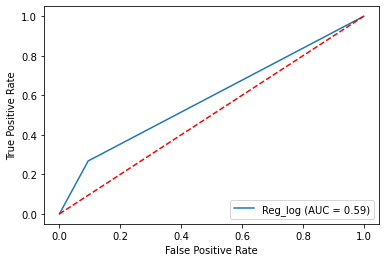

In [32]:
log_reg = LogisticRegression().fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

# Probabilidades de Y con valores 1 o 0 en base a regla de Bayes
y_pred_log = np.where(y_pred_log > 0.5, 1, y_pred_log)
y_pred_log = np.where(y_pred_log <= 0.5, 0, y_pred_log)

accuracy_log = accuracy_score(y_test, y_pred_log)


# Calculamos la matriz de confusion y la precision del modelo
matriz_confusion_log = confusion_matrix(y_test, y_pred_log)

print('Matriz de confusión Logit:')
print(matriz_confusion_log) 
print("La precisión del modelo es: %.2f" %accuracy_log)

#Valor auc
auc_log = roc_auc_score(y_test, y_pred_log)
print('AUC: %.2f' % auc_log)

#Graficamos la curva ROC

fpr, tpr, thresholds = roc_curve(y_test, y_pred_log)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_log, estimator_name='Reg_log')
display.plot()  
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.show()

#### Análisis de discriminante lineal

Matriz de confusión Análisis de discriminante lineal:
[[686  76]
 [271  91]]
La precisión del modelo es: 0.69
AUC: 0.58


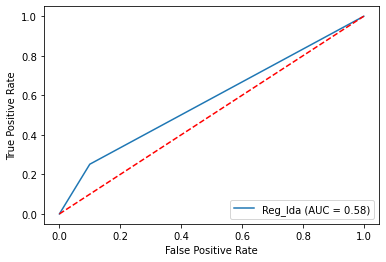

In [33]:
lda = LinearDiscriminantAnalysis(n_components=0)
lda = lda.fit(X_train, y_train)
y_pred_lda = lda.predict(X_test)
accuracy_lda = accuracy_score(y_test, y_pred_lda)

# Calculamos la matriz de confusion y la precision del modelo
matriz_confusion_lda = confusion_matrix(y_test, y_pred_lda)

print('Matriz de confusión Análisis de discriminante lineal:')
print(matriz_confusion_lda) 
print("La precisión del modelo es: %.2f" %accuracy_lda)

# Valor auc
auc_lda = roc_auc_score(y_test, y_pred_lda)
print('AUC: %.2f' % auc_lda)

# Graficamos la curva ROC

fpr, tpr, thresholds = roc_curve(y_test, y_pred_lda)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_lda, estimator_name='Reg_lda')
display.plot()  
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.show() 

#### KNN con k=3

Matriz de confusión KNN:
[[636 126]
 [202 160]]
La precisión del modelo es: 0.71
AUC: 0.64


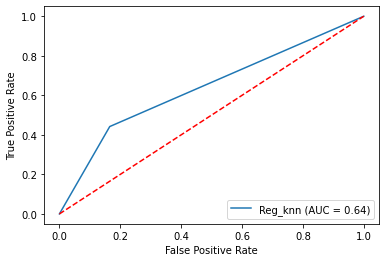

In [34]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)

# Calculamos la matriz de confusion y la precision del modelo
matriz_confusion_knn = confusion_matrix(y_test, y_pred_knn)

print('Matriz de confusión KNN:')
print(matriz_confusion_knn) 
print("La precisión del modelo es: %.2f" %accuracy_knn)

# Valor auc
auc_knn = roc_auc_score(y_test, y_pred_knn)
print('AUC: %.2f' % auc_knn)

# Graficamos la curva ROC

fpr, tpr, thresholds = roc_curve(y_test, y_pred_knn)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_knn, estimator_name='Reg_knn')
display.plot()  
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.show() 

#### 5. Con el método que seleccionó, prediga qué personas son pobres dentro de la base norespondieron. ¿Qué proporción de las personas que no respondieron pudo identificar como pobres?

In [35]:
# Armamos la muestra de testeo entre los que no respondieron, de la misma forma que hicimos con los que respondieron.

x_test_noresp = norespondieron[['CH06', 'CH04' , 'ESTADO', 'NIVEL_ED' , 'CH03' , 'CH07' , 'CH08',  'CH09' , 'CH10' , 'CH11', 'CH12' , 'CH13' , 'CH16' ,'PP02C1', 'PP02C2', 'PP02C3', 'PP02C4', 'PP02C6', 'PP02E','PP02H'
]]

x_test_noresp = sm.add_constant(x_test_noresp) # Agregamos la columna de unos.

In [36]:
# Predecimos la cantidad de pobres dentro de los no respondents con el modelo KNN, dándole la muestra que armamos arriba.

y_pred_knn_noresp = knn.predict(x_test_noresp)

# Realizamos la suma de pobres predichos por KNN
sum_pob = sum(1 for i in y_pred_knn_noresp if i == 1)

# Buscamos la proporción de personas pobres que predice KNN para el total de individuos que no respondieron.

prop_pob = (sum_pob/len(y_pred_knn_noresp))*100

print("La proporción de pobres predicha en la base norespondieron es de %.2f" %prop_pob)

La proporción de pobres predicha en la base norespondieron es de 29.30


#### 6. Note que para correr los tres métodos se utilizaron todas las variables disponibles como predictores. ¿Le parece esto correcto? ¿Qué variables habría conservado? Con las variables seleccionadas, implemente únicamente el modelo logit nuevamente y compare las medidas de precisión obtenidas con los resultados del modelo logit anterior. ¿Cambió mucho la precisión?

In [37]:
# Creamos una nueva base donde solo conservamos las variables explicativas que nos interesan.
respondieron_filt = respondieron[['pobre', 'CH06', 'ESTADO', 'NIVEL_ED']]
y_filt = respondieron_filt['pobre']
x_filt = respondieron_filt[['CH06', 'ESTADO', 'NIVEL_ED']]

x_filt = sm.add_constant(x_filt) # Agregamos la columna de unos.

x['NIVEL_ED'] = pd.Categorical(x['NIVEL_ED'])
x['ESTADO'] = pd.Categorical(x['ESTADO'])

# Partimos la base en una de entrenamiento (70%) y otra de prueba (30%)

X_filt_train, X_filt_test, y_filt_train, y_filt_test = train_test_split(x_filt, y_filt, test_size = 0.30, random_state=101)

In [38]:
log_reg_filt = LogisticRegression().fit(X_filt_train, y_filt_train)
y_pred_log_filt = log_reg_filt.predict(X_filt_test)

# Probabilidades de Y con valores 1 o 0 en base a regla de Bayes
y_pred_log_filt = np.where(y_pred_log_filt > 0.5, 1, y_pred_log_filt)
y_pred_log_filt = np.where(y_pred_log_filt <= 0.5, 0, y_pred_log_filt)

# Medidas de precisión y comparaciones

accuracy_log_filt = accuracy_score(y_filt_test, y_pred_log_filt)
auc_log_filt = roc_auc_score(y_filt_test, y_pred_log_filt)
matriz_confusion_log_filt = confusion_matrix(y_filt_test, y_pred_log_filt)

print("La precisión del modelo anterior es de %.2f," %accuracy_log, "mientras que en el modelo actual es de %.2f." %accuracy_log_filt)
print("El área bajo la curva ROC original es de %.2f," % auc_log, "mientras que para el modelo actual este valor alcanza el %.2f." %auc_log_filt)


print('Matriz de confusión Logit original:')
print(matriz_confusion_log) 

print('Matriz de confusión Logit actual:')
print(matriz_confusion_log_filt) 

La precisión del modelo anterior es de 0.70, mientras que en el modelo actual es de 0.67.
El área bajo la curva ROC original es de 0.59, mientras que para el modelo actual este valor alcanza el 0.54.
Matriz de confusión Logit original:
[[690  72]
 [265  97]]
Matriz de confusión Logit actual:
[[699  63]
 [305  57]]
